# 1. Долгая версия, в лоб, очень медленно работает

In [19]:
import numpy as np
from PIL import Image

def sobel_edge_detection(img_path: str, low_threshold: int=50, high_threshold: int=150):
    """
    Функция поиска границ с помощью оператора собеля
    Параметры:
    img_path - str, путь к картинке
    low_threshold=50 - int, нижний порог при двойной пороговой фильтрации
    high_threshold=150 - int, верхний порог при двойной пороговой фильтрации
    """
    # открываем изображение и переводим в чб
    img = Image.open(img_path).convert('L')
    img_array = np.array(img, dtype=np.float32)

    # функция свертки 
    def convolve(img_array: np.ndarray, kernel: np.ndarray):
        """Свертка с заданным ядром. Краевые случаи обрабатываются"""
        height, width = img_array.shape
        kernel_height, kernel_width = kernel.shape
        # определяем размеры паддинга (чтобы обработать краевые случаи)
        pad_height = kernel_height // 2
        pad_width = kernel_width // 2

        # расширяем изображение для обработки краевых случаев. Выбрал reflect, чтобы 
        # не ловить артефакты на границах (оставить плавные переходы)
        padded_img = np.pad(img_array, ((pad_height, pad_height), (pad_width, pad_width)), mode='reflect')

        # куда будем записывать результат
        output = np.zeros((height, width), dtype=np.float32)

        # применяем свертку
        for i in range(height):
            for j in range(width):
                output[i, j] = np.sum(padded_img[i:i + kernel_height, j:j + kernel_width] * kernel)

        return output

    # ядра Собеля 
    sobel_x_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y_kernel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # сворачиваем по двум осям
    grad_x = convolve(img_array, sobel_x_kernel)
    grad_y = convolve(img_array, sobel_y_kernel)

    # находим величину и направление градиента для каждого пикселя
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    direction = np.arctan2(grad_y, grad_x)

    # non-maximum suppression
    def non_maximum_suppression(magnitude, direction):
        """Подавление локальных немаксимумов градиента"""
        height, width = magnitude.shape
        output = np.zeros((height, width), dtype=np.float32)

        # преобразуем направление градиента в углы от 0 до 180
        direction_degree = direction * 180 / np.pi 
        direction_degree[direction_degree < 0] += 180

        for i in range(1, height - 1):
            for j in range(1, width - 1):
                angle = direction_degree[i, j]

                # рассматриваем 4 направления градиента
                if (0 <= angle < 22.5) or (157.5 <= angle <= 180): # горизонтальное
                    neighbors = [magnitude[i, j - 1], magnitude[i, j + 1]]
                elif 22.5 <= angle < 67.5: # диагональное 
                    neighbors = [magnitude[i - 1, j - 1], magnitude[i + 1, j + 1]]
                elif 67.5 <= angle < 112.5: # вертикальное 
                    neighbors = [magnitude[i - 1, j], magnitude[i + 1, j]]
                elif 112.5 <= angle < 157.5: # другое диагональное 
                    neighbors = [magnitude[i - 1, j + 1], magnitude[i + 1, j - 1]]

                # сравниеваем градиент с соседними пикселями (в направлении градиента)
                # и если он не локальный максимум, то зануляем (подавляем) его
                if magnitude[i, j] >= neighbors[0] and magnitude[i, j] >= neighbors[1]:
                    output[i, j] = magnitude[i, j]
                else:
                    output[i, j] = 0

        return output

    nms_output = non_maximum_suppression(magnitude, direction)

    # двойная пороговая фильтрация
    def double_thresholding(img, low_threshold, high_threshold):
        """Применяет двойную пороговую фильтрацию"""
        strong_pixels = (img >= high_threshold)
        weak_pixels = ((img >= low_threshold) & (img < high_threshold))
        return strong_pixels, weak_pixels

    strong_pixels, weak_pixels = double_thresholding(nms_output, low_threshold, high_threshold)

    def hysteresis(strong_pixels, weak_pixels):
        """Применяет гистерезис, чтобы соединить слабые границы с сильными, если они находятся рядом"""
        height, width = strong_pixels.shape
        output = np.zeros((height, width), dtype=np.uint8)
        output[strong_pixels] = 255

        for i in range(1, height - 1):
            for j in range(1, width - 1):
                if weak_pixels[i, j]:
                    if np.any(strong_pixels[i-1:i+2, j-1:j+2]):
                        output[i, j] = 255

        return output

    edge_image = hysteresis(strong_pixels, weak_pixels)

    return edge_image


Пример использования и сравнение с Кэнни


In [27]:

import matplotlib.pyplot as plt
import cv2
from time import time

def show(low_threshold=50, high_threshold=150):
    for image_path in ("женщина.jpg", "мужчина.png", "поршень.jpg", "чайник.jpg", "шахматы.jpg", "image.jpg"):

        img_original = Image.open(image_path)

        # Собель
        start = time()
        edge_image = sobel_edge_detection(image_path, low_threshold, high_threshold)
        end_my = time() - start

        # cv2.Canny

        img_cv2 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        start = time()
        edges_cv2 = cv2.Canny(img_cv2, low_threshold, high_threshold)
        end_canny = time() - start

        # результаты
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img_original, cmap='gray')
        plt.title(f'Исходное изображение {img_original.size}')

        plt.subplot(1, 3, 2)
        plt.imshow(edge_image, cmap='gray')
        plt.title(f'Собель {end_my} сек.')

        plt.subplot(1, 3, 3)
        plt.imshow(edges_cv2, cmap='gray')
        plt.title(f'Canny {end_canny} сек.')

        plt.tight_layout()
        plt.show()

/tmp/ipykernel_568208/1287895859.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img_array = np.array(img, dtype=np.float32)


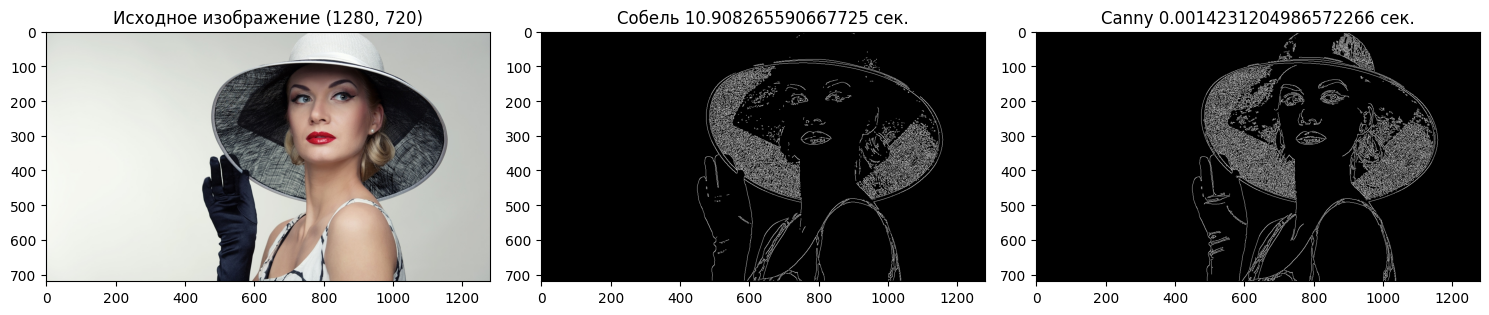

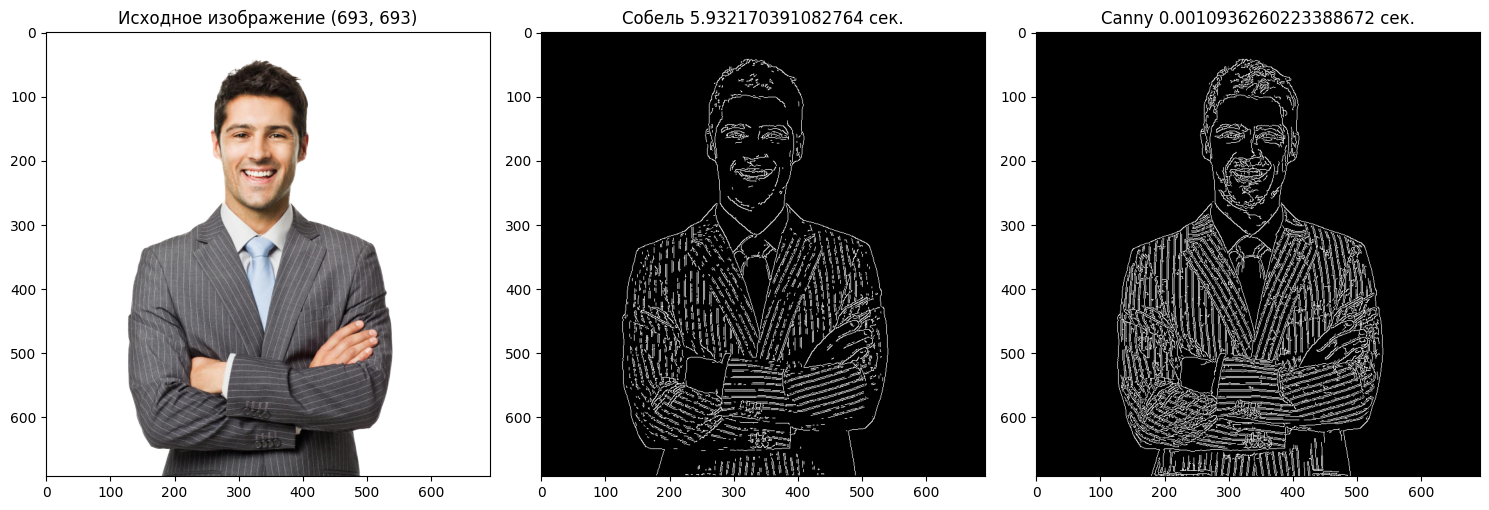

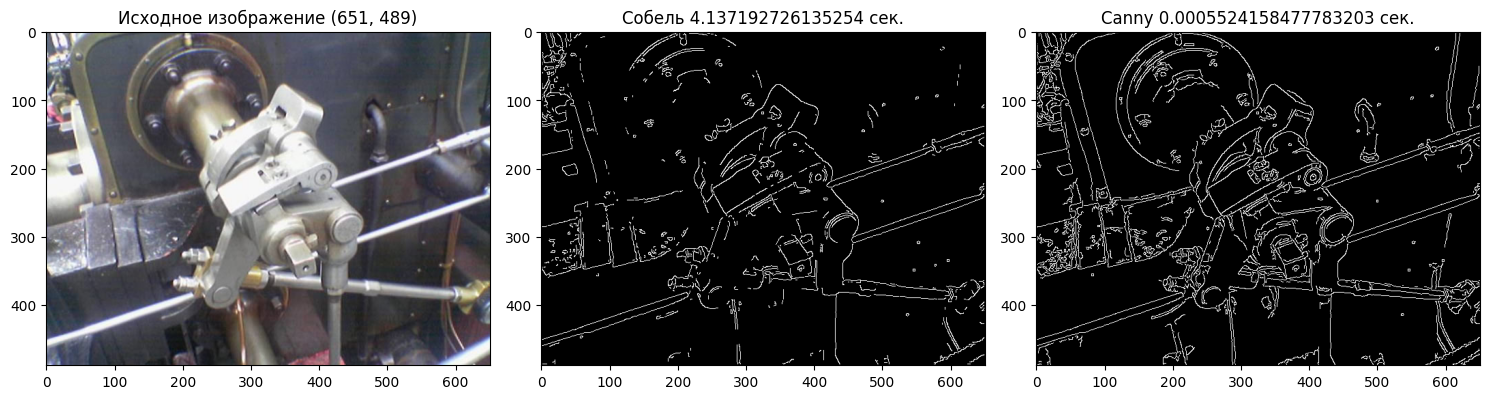

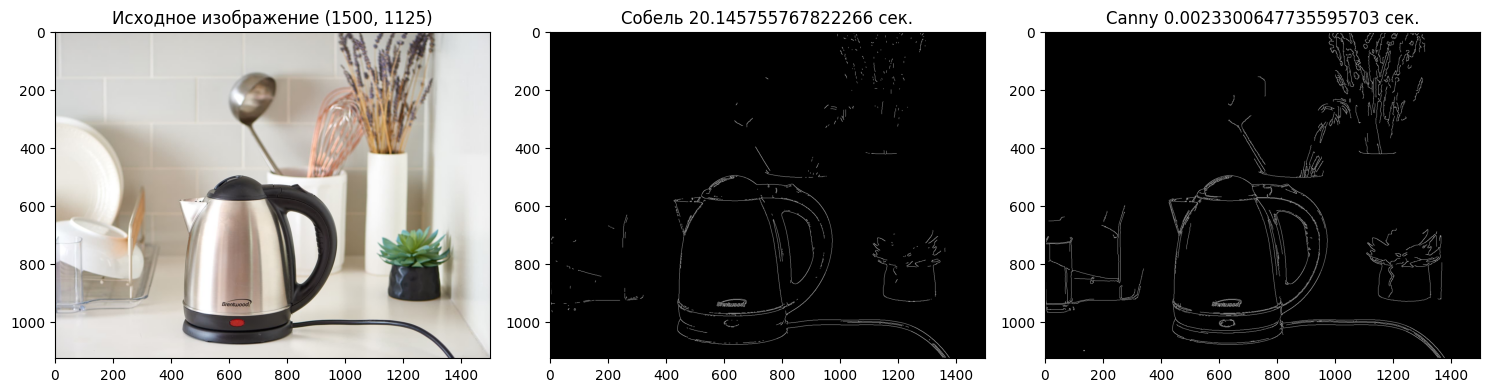

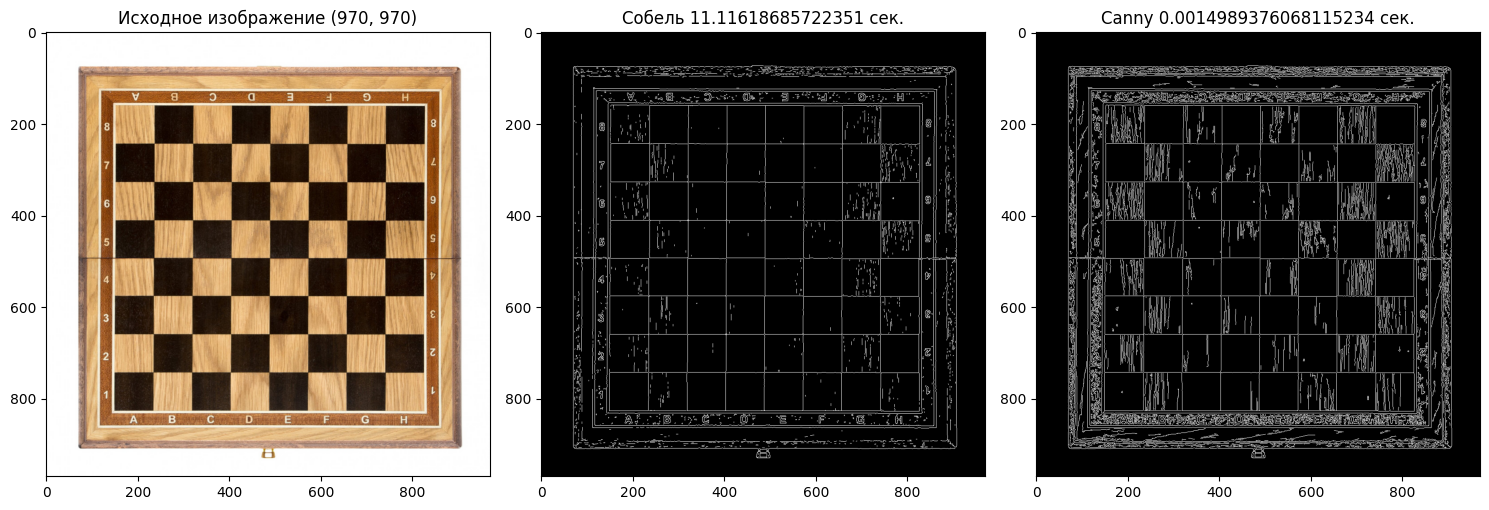

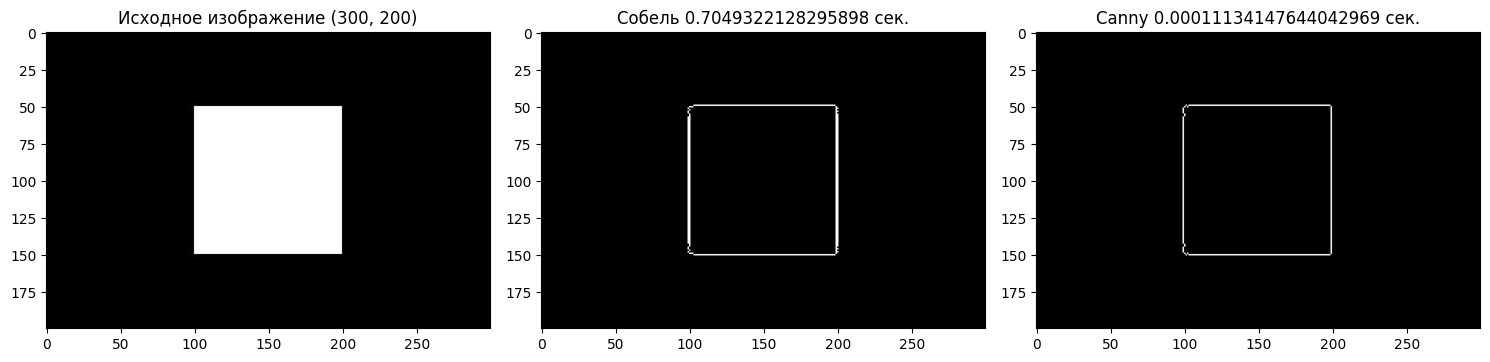

In [24]:
show()

# 2. Более эффективная версия (без циклов)

In [25]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from PIL import Image

def sobel_edge_detection(img_path: str, low_threshold: int=50, high_threshold: int=150):
    """
    Функция поиска границ с помощью оператора собеля
    Параметры:
    img_path - str, путь к картинке
    low_threshold=50 - int, нижний порог при двойной пороговой фильтрации
    high_threshold=150 - int, верхний порог при двойной пороговой фильтрации
    """
    # открываем изображение и переводим в чб
    img = Image.open(img_path).convert('L')
    img_array = np.array(img, dtype=np.float32)

    # оптимизированная функция свертки 
    def convolve(img_array: np.ndarray, kernel: np.ndarray):
        """Свертка с заданным ядром. Краевые случаи обрабатываются"""
        kernel_height, kernel_width = kernel.shape
        # определяем размеры паддинга (чтобы обработать краевые случаи)
        pad_height = kernel_height // 2
        pad_width = kernel_width // 2

        # расширяем изображение для обработки краевых случаев. Выбрал reflect, чтобы 
        # не ловить артефакты на границах (оставить плавные переходы)
        padded_img = np.pad(img_array, ((pad_height, pad_height), (pad_width, pad_width)), mode='reflect')

        # создаем скользящее окно
        windows = sliding_window_view(padded_img, (kernel_height, kernel_width))

        # выполняем свертку
        output = np.sum(windows * kernel, axis=(2, 3))

        return output

    # ядра Собеля 
    sobel_x_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y_kernel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # сворачиваем по двум осям
    grad_x = convolve(img_array, sobel_x_kernel)
    grad_y = convolve(img_array, sobel_y_kernel)

    # находим величину и направление градиента для каждого пикселя
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    direction = np.arctan2(grad_y, grad_x)

    # non-maximum suppression
    def non_maximum_suppression(magnitude, direction):
        """Подавление локальных немаксимумов градиента"""
        height, width = magnitude.shape
        output = np.zeros((height, width), dtype=np.float32)

        # преобразуем направление градиента в углы от 0 до 180
        direction_degree = direction * 180 / np.pi 
        direction_degree[direction_degree < 0] += 180

        # горизонтальное
        mask_0 = ((0 <= direction_degree) & (direction_degree < 22.5)) | ((157.5 <= direction_degree) & (direction_degree <= 180))
        # диагональное
        mask_45 = (22.5 <= direction_degree) & (direction_degree < 67.5)
        # вертикальное 
        mask_90 = (67.5 <= direction_degree) & (direction_degree < 112.5)
        # другое диагональное 
        mask_135 = (112.5 <= direction_degree) & (direction_degree < 157.5)
        
        # сдвигаем изображение для сравнения с соседними пикселями
        padded_magnitude = np.pad(magnitude, ((1, 1), (1, 1)), mode='constant')
       
        # сравниваем
        output[mask_0] = np.where(
            (magnitude[mask_0] >= padded_magnitude[1:-1, :-2][mask_0]) & 
            (magnitude[mask_0] >= padded_magnitude[1:-1, 2:][mask_0]),
            magnitude[mask_0], 0
        )

        output[mask_45] = np.where(
            (magnitude[mask_45] >= padded_magnitude[:-2, :-2][mask_45]) & 
            (magnitude[mask_45] >= padded_magnitude[2:, 2:][mask_45]),
            magnitude[mask_45], 0
        )

        output[mask_90] = np.where(
            (magnitude[mask_90] >= padded_magnitude[:-2, 1:-1][mask_90]) & 
            (magnitude[mask_90] >= padded_magnitude[2:, 1:-1][mask_90]),
            magnitude[mask_90], 0
        )

        output[mask_135] = np.where(
            (magnitude[mask_135] >= padded_magnitude[:-2, 2:][mask_135]) & 
            (magnitude[mask_135] >= padded_magnitude[2:, :-2][mask_135]),
            magnitude[mask_135], 0
        )

        return output

    nms_output = non_maximum_suppression(magnitude, direction)

    # двойная пороговая фильтрация
    def double_thresholding(img, low_threshold, high_threshold):
        """Применяет двойную пороговую фильтрацию"""
        strong_pixels = (img >= high_threshold)
        weak_pixels = ((img >= low_threshold) & (img < high_threshold))
        return strong_pixels, weak_pixels

    strong_pixels, weak_pixels = double_thresholding(nms_output, low_threshold, high_threshold)

    def hysteresis(strong_pixels, weak_pixels):
        """Применяет гистерезис, чтобы соединить слабые границы с сильными, если они находятся рядом"""
        # добавляем паддинг к сильным границам
        padded_strong = np.pad(strong_pixels, ((1, 1), (1, 1)), mode='constant')

        # создаем скользящее окно 3x3
        windows = sliding_window_view(padded_strong, (3, 3))

        # gроверяем, есть ли хотя бы одна сильная граница в окрестности 3x3
        strong_expanded = np.any(windows, axis=(2, 3))

        # cохраняем слабые границы, если они пересекаются с расширенными сильными
        output = np.zeros_like(strong_pixels, dtype=np.uint8)
        output[strong_pixels] = 255
        output[weak_pixels & strong_expanded] = 255

        return output

    edge_image = hysteresis(strong_pixels, weak_pixels)

    return edge_image


/tmp/ipykernel_568208/402229554.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img_array = np.array(img, dtype=np.float32)


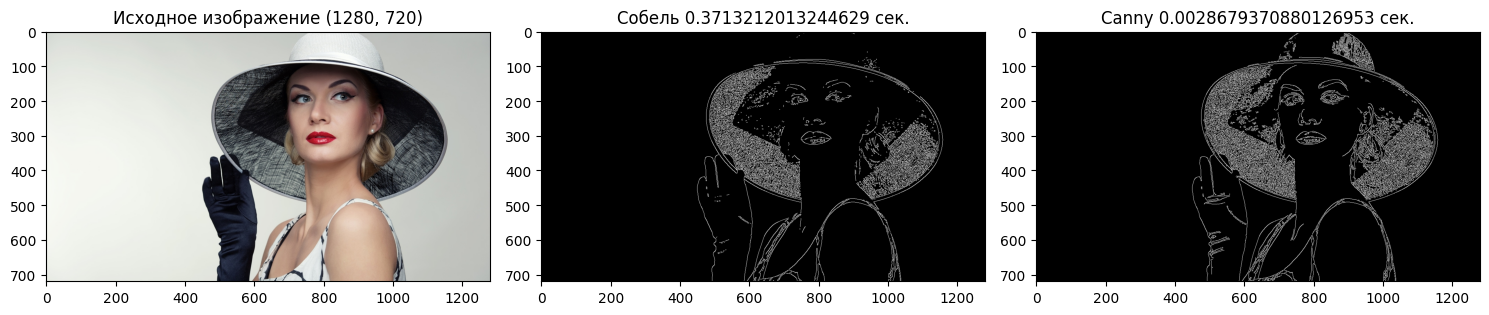

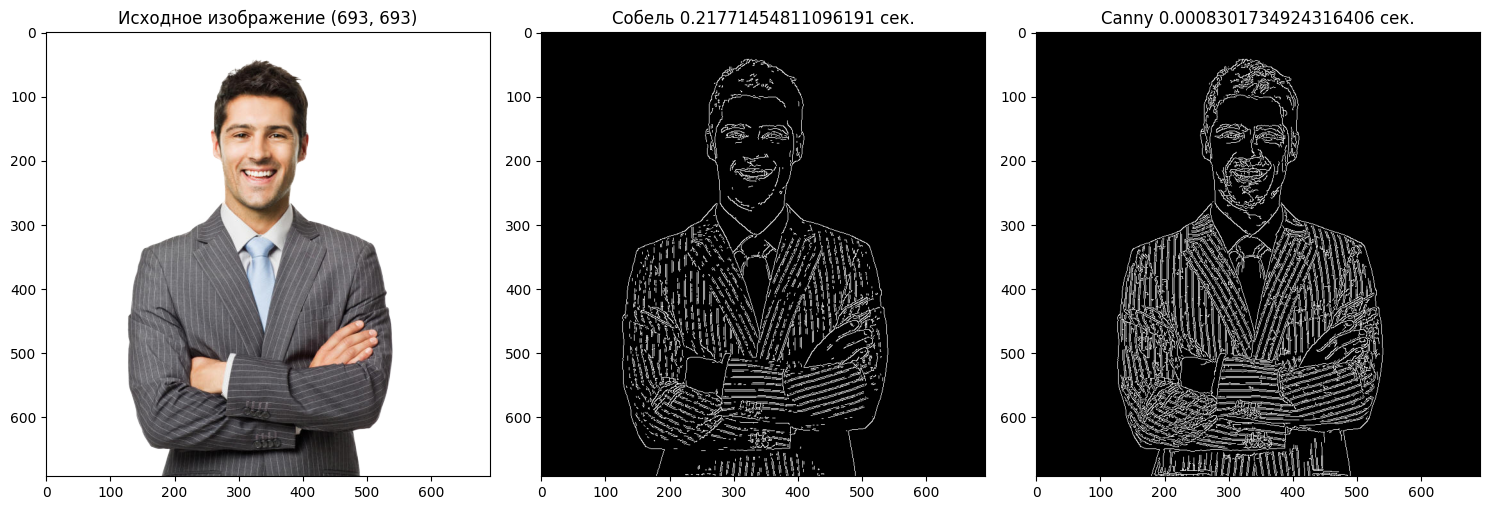

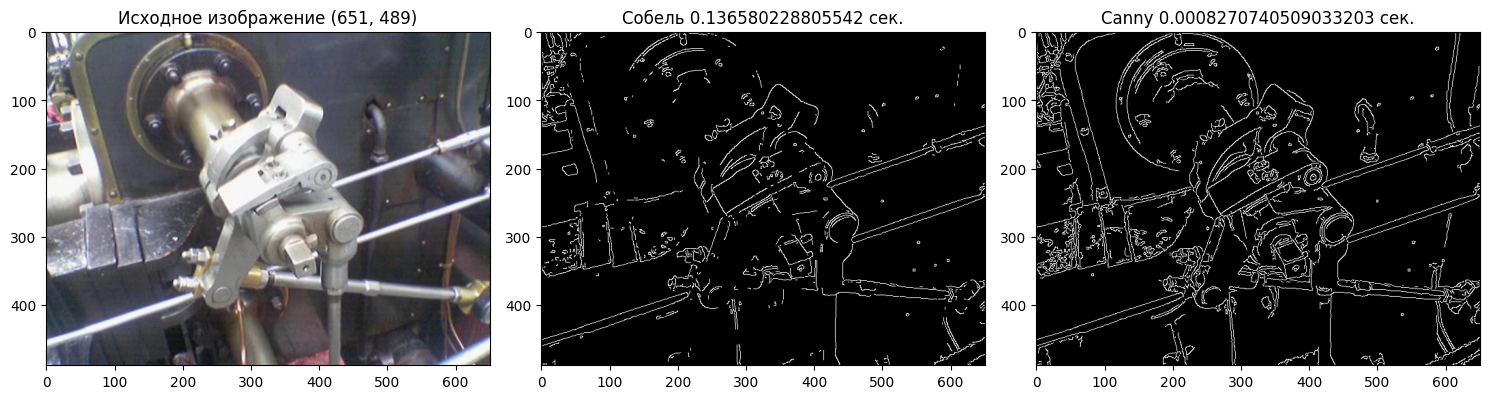

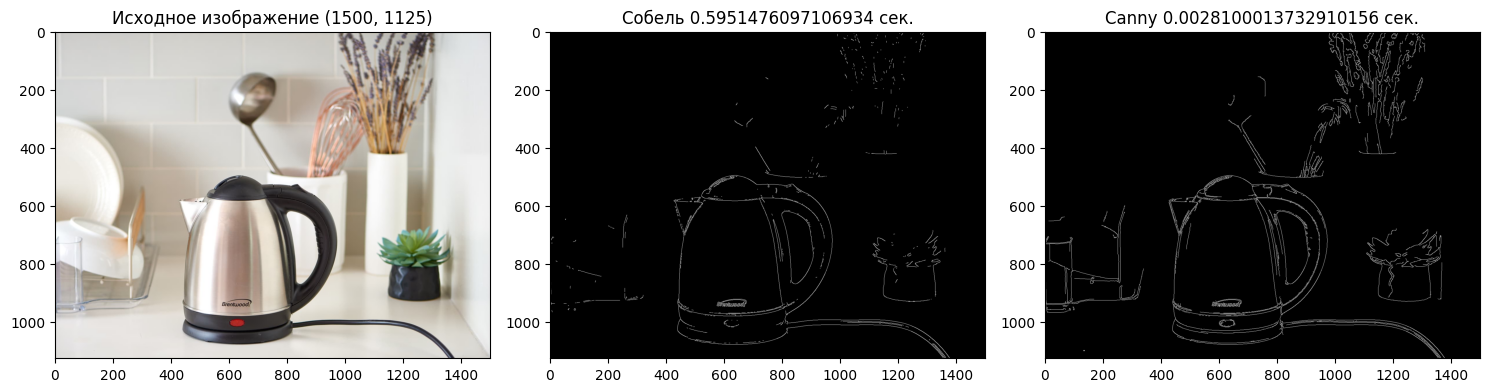

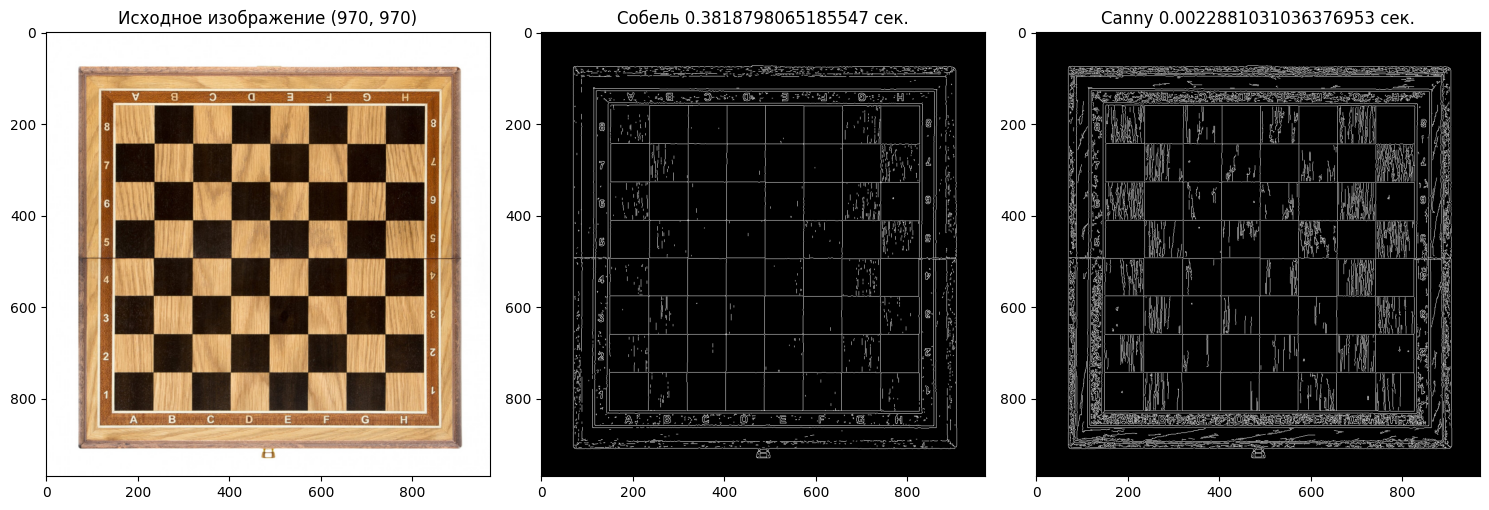

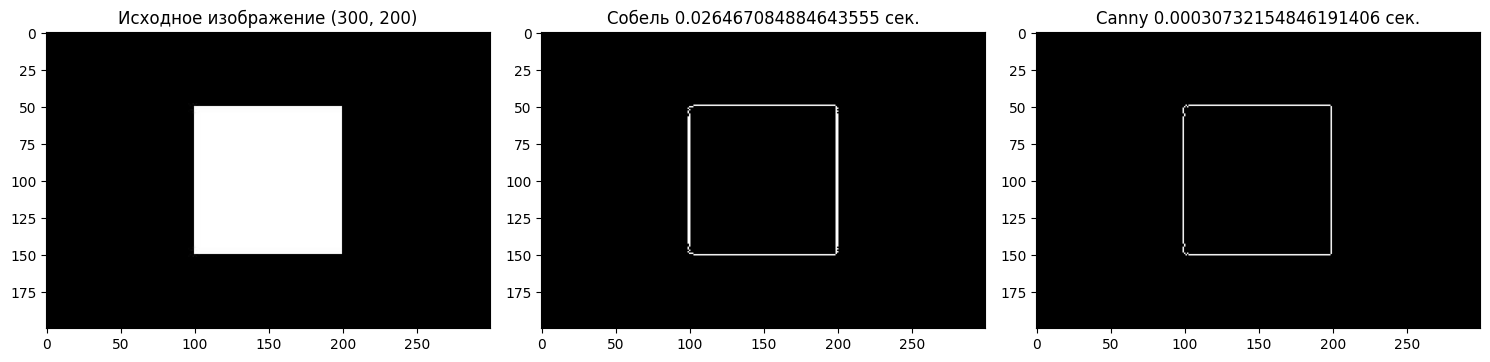

In [26]:
show()